In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

# The tf.data API

In [ ]:
import tensorflow as tf

X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [ ]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [ ]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## Chaining Transformations

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [ ]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [ ]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [ ]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


## Shuffling the Data

In [ ]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### Interleaving lines from multiple files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set:

In [ ]:
# Fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:

In [ ]:
# Split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [ ]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [ ]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

**Building an Input Pipeline**

In [ ]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [ ]:
# Shows that the file paths are shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [ ]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [ ]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


## Preprocessing the Data

In [ ]:
# Compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [ ]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [ ]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

## Putting Everything Together + Prefetching

In [ ]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [ ]:
# Show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



## Using the Dataset with Keras

In [ ]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [ ]:
# For reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 1.3569 - val_loss: 0.5272
Epoch 2/5
363/363 [==============================] - 0s 965us/step - loss: 0.5132 - val_loss: 63.7862
Epoch 3/5
363/363 [==============================] - 0s 902us/step - loss: 0.5916 - val_loss: 20.3634
Epoch 4/5
363/363 [==============================] - 1s 944us/step - loss: 0.5089 - val_loss: 0.3993
Epoch 5/5
363/363 [==============================] - 1s 905us/step - loss: 0.4200 - val_loss: 0.3639


In [ ]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

162/162 [==============================] - 0s 594us/step - loss: 0.3868


In [ ]:
# Defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # Perform one Gradient Descent step
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [ ]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

# The TFRecord Format

A TFRecord file is just a list of binary records. You can create one using a `tf.io.TFRecordWriter`:

In [ ]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can read it using a `tf.data.TFRecordDataset`:

In [ ]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [ ]:
# Shows how to read multiple files in parallel and interleave them

filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## Compressed TFRecord Files

In [ ]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [ ]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")

In [ ]:
# Shows that the data is decompressed correctly
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


## A Brief Introduction to Protocol Buffers

In [ ]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting person.proto


In [ ]:
import os

IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    !apt remove -y protobuf-compiler
    PB_REL="https://github.com/protocolbuffers/protobuf/releases"
    !curl -LO {PB_REL}/download/v25.1/protoc-25.1-linux-x86_64.zip
    !unzip protoc-25.1-linux-x86_64.zip -d /root/.local
    os.environ["PATH"] += ":/root/.local/bin"

And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [ ]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [ ]:
%ls person*

person.desc    person.proto   person_pb2.py


In [ ]:
from person_pb2 import Person  # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [ ]:
person.name  # read a field

'Al'

In [ ]:
person.name = "Alice"  # modify a field

In [ ]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [ ]:
person.email.append("c@d.com")  # add an email address

In [ ]:
serialized = person.SerializeToString()  # serialize person to a byte string
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [ ]:
person2 = Person()  # create a new Person
person2.ParseFromString(serialized)  # parse the byte string (27 bytes long)

27

In [ ]:
person == person2  # now they are equal

True

### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [ ]:
# Shows how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

## TensorFlow Protobufs

Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

In [ ]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

## Loading and Parsing Examples

In [ ]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f829147c040>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f82390756a0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8239068a60>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f829147b310>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f829155d850>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: s

In [ ]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [ ]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [ ]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [ ]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8281729dc0>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8239068f40>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f8239075b50>, 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}


In [ ]:
parsed_examples

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f8239075b50>,
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

## Extra Material – Storing Images and Tensors in TFRecords

Let's load and display an example image:

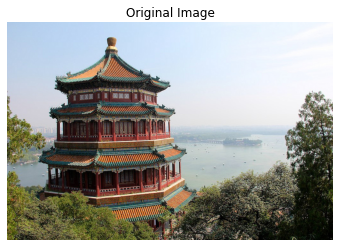

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

Now let's create an `Example` protobuf containing the image encoded as JPEG:

In [ ]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

Finally, let's create a tf.data pipeline that will read this TFRecord file, parse each `Example` protobuf (in this case just one), and parse and display the image that the example contains:

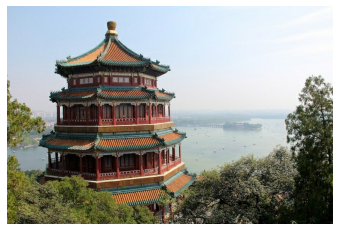

In [ ]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])

dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [ ]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [ ]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [ ]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [ ]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

## Handling Lists of Lists Using the `SequenceExample` Protobuf

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

In [ ]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [ ]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [ ]:
serialized_sequence_example = sequence_example.SerializeToString()

In [ ]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [ ]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [ ]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f8281d310d0>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [ ]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [ ]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f8281d31be0>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f8281d31280>}

In [ ]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# Keras Preprocessing Layers

## The `Normalization` Layer

In [ ]:
tf.random.set_seed(42)  # ensures reproducibility
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)  # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 863us/step - loss: 2.6287 - val_loss: 1.2771
Epoch 2/5
363/363 [==============================] - 0s 691us/step - loss: 0.8460 - val_loss: 1.3751
Epoch 3/5
363/363 [==============================] - 0s 729us/step - loss: 0.6995 - val_loss: 1.2119
Epoch 4/5
363/363 [==============================] - 0s 716us/step - loss: 0.6606 - val_loss: 0.8703
Epoch 5/5
363/363 [==============================] - 0s 696us/step - loss: 0.6374 - val_loss: 0.6106


In [ ]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [ ]:
tf.random.set_seed(42)  # ensures reproducibility
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 0s 806us/step - loss: 2.6287 - val_loss: 1.2771
Epoch 2/5
363/363 [==============================] - 0s 642us/step - loss: 0.8460 - val_loss: 1.3751
Epoch 3/5
363/363 [==============================] - 0s 647us/step - loss: 0.6995 - val_loss: 1.2119
Epoch 4/5
363/363 [==============================] - 0s 669us/step - loss: 0.6606 - val_loss: 0.8703
Epoch 5/5
363/363 [==============================] - 0s 651us/step - loss: 0.6374 - val_loss: 0.6106


In [ ]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new)  # preprocesses the data and makes predictions

In [ ]:
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.0205517],
       [1.5699625],
       [2.460654 ]], dtype=float32)>

In [ ]:
# creates a dataset to demo applying the norm_layer using map()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)

In [ ]:
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

In [ ]:
list(dataset.take(1))  # shows the first batch

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.1939791 , -1.0778134 , -0.9433871 ,  0.0148516 ,  0.02073434,
          -0.572917  ,  0.92925584, -1.4221287 ],
         [ 0.7519827 , -1.8688954 ,  0.40547717, -0.23327832,  1.8614666 ,
           0.20516507, -0.9165531 ,  1.0966995 ],
         [-0.41469136,  0.02970134,  0.8180875 ,  1.0567819 , -0.08786613,
          -0.29983336,  1.3087229 , -1.6970023 ],
         [ 1.7188951 , -1.315138  ,  0.32664284, -0.21955258, -0.337921  ,
          -0.11146677, -0.9821399 ,  0.9417729 ],
         [-0.96207225, -1.2360299 , -0.05625898, -0.03124549,  1.709061  ,
          -0.30257043, -0.8041173 ,  1.3265921 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [ ]:
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # a small smoothing term
        return (inputs - self.mean_) / (self.std_ + eps)

In [ ]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

## The `Discretization` Layer

In [ ]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [ ]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

## The `CategoryEncoding` Layer

In [ ]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [ ]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [ ]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

In [ ]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # adds 3 to the second feature

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [ ]:
# shows another way to one-hot encode each feature separately
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3,
                                                output_mode="one_hot")
tf.keras.layers.concatenate([onehot_layer(cat)
                             for cat in tf.transpose(two_age_categories)])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [ ]:
# shows another way to do this, using tf.one_hot() and Flatten
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

## The `StringLookup` Layer

In [ ]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

In [ ]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

In [ ]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>